### Uma Tendências Virais nas Redes Sociais e Engajamento

**Nome: Roberta Alvarez Martins**

### 1- OBJETIVO
### 

Temos dois problemas a serem resolvidos com esse trabalho:

1.**Qual plataforma dá mais engajamento?**
Problema: Como o engajamento (Views, Likes, Shares e Comments) varia entre diferentes plataformas (TikTok, Instagram, Twitter, YouTube)?

Objetivo: Entender qual plataforma gera mais engajamento



2.**Identificação de Hashtags com Maior Impacto**
Problema: Quais hashtags estão associadas aos posts com maior engajamento (views, likes, shares, e comments)?

Objetivo: Identificar hashtags populares que estão impulsionando o engajamento e entender quais tendências estão por trás dessas hashtags.


### 2-**Descrição resumida dos dados**

O dataset contém registros de posts em redes sociais, abrangendo plataformas como TikTok, Instagram, Twitter e YouTube. Cada entrada inclui informações como ID do post, plataforma, hashtag associada, tipo de conteúdo (vídeo, postagem, etc.), região de origem, métricas de engajamento (visualizações, curtidas, compartilhamentos, comentários) e nível de engajamento (alto, médio, baixo). Os dados são variados, cobrindo diferentes categorias de conteúdo (desafios, educação, dança, jogos, etc.) e regiões globais (como Brasil, Índia, EUA, Reino Unido, entre outros)

**Número total de linhas (posts)**: 1,644 (incluindo o cabeçalho)

**Número total de colunas**: 10

**Abaixo as descrições das colunas do DATASET : **

**Post_ID**– Identificador único do post (ex: Post_1, Post_2).

**Platform **– Plataforma onde o post foi publicado (ex: TikTok, Instagram, Twitter, YouTube).

**Hashtag** – Hashtag principal associada ao post (ex: #Challenge, #Education, #Dance).

**Content_Type** – Tipo de conteúdo do post (ex: Video, Shorts, Post, Live Stream, Reel, Tweet).

**Region** – País ou região de origem do post (ex: UK, India, Brazil, USA, Japan).

**Views** – Número de visualizações do post (valor numérico).

**Likes** – Número de curtidas recebidas (valor numérico).

**Shares** – Número de compartilhamentos (valor numérico).

**Comments** – Número de comentários (valor numérico).

**Engagement_Level** – Classificação do engajamento do post (High, Medium, Low), provavelmente baseada em métricas combinadas de curtidas, compartilhamentos e comentários.

Valores Mínimos e Máximos das Métricas Numéricas

Métrica	valor mínimo e máximo:

**Views** Min:6.86	Max: 4.977.438	


**Likes**	Min 863	Max : 496.078	

**Shares**	Min 80	Max 99.754	

**Comments**	Min 18	Max 49.197

## **OBS:Não foi necessário fazer transformação nos dados pois a tabela estava perfeita, sem valores brancos, nulos ou inválidos
## **

### **3- Busca pelos DADOS**

Fonte dos dados:
Utilizarei o arquivo "Viral_Social_Media_Trends.csv" O conjunto de dados foi baixado do Site Kaggle. Link para os Dados: https://www.kaggle.com/datasets/atharvasoundankar/viral-social-media-trends-and-engagement-analysis/data

### **4. Coleta**
Os dados foram baixados do Kaggle e armazenados localmente. Posteriormente, foram carregados para o Databricks File System (DBFS) para facilitar o processamento e a análise na nuvem.

Fonte dos Dados: Kaggle

Local de Armazenamento: dbfs:/FileStore/mvp/Viral_Social_Media_Trends.csv

Licença de Uso: Licença Kaggle

### 4.1-  Código para coleta e armazenamento:
### 


In [0]:
# Definir o caminho do arquivo CSV no Databricks
file_path = 'dbfs:/FileStore/mvp/Viral_Social_Media_Trends.csv'

# Carregar o dataset do arquivo CSV para um DataFrame do Spark
df = spark.read.option("header", "true").csv(file_path)

# Mostrar as primeiras linhas do dataset para verificar se a carga foi bem-sucedida
df.show(5)

# Conversão de colunas numéricas (Views, Likes, Shares, Comments) para o tipo apropriado
df = df.withColumn("Views", df["Views"].cast("int"))
df = df.withColumn("Likes", df["Likes"].cast("int"))
df = df.withColumn("Shares", df["Shares"].cast("int"))
df = df.withColumn("Comments", df["Comments"].cast("int"))

# Exibir o esquema do DataFrame para verificar os tipos de dados
df.printSchema()

# Definir o caminho para armazenamento no formato Delta
delta_storage_path = '/mnt/delta/viral_social_media_data'

# Salvar os dados em formato Delta no Databricks (permite consultas eficientes e escaláveis)
df.write.format("delta").mode("overwrite").save(delta_storage_path)

# Para garantir que o Delta Lake foi configurado corretamente, você pode ler os dados novamente e verificar
df_delta = spark.read.format("delta").load(delta_storage_path)
df_delta.show(5)

# Exibir o esquema dos dados armazenados no Delta Lake
df_delta.printSchema()


+-------+---------+----------+------------+---------+-------+------+------+--------+----------------+
|Post_ID| Platform|   Hashtag|Content_Type|   Region|  Views| Likes|Shares|Comments|Engagement_Level|
+-------+---------+----------+------------+---------+-------+------+------+--------+----------------+
| Post_1|   TikTok|#Challenge|       Video|       UK|4163464|339431| 53135|   19346|            High|
| Post_2|Instagram|#Education|      Shorts|    India|4155940|215240| 65860|   27239|          Medium|
| Post_3|  Twitter|#Challenge|       Video|   Brazil|3666211|327143| 39423|   36223|          Medium|
| Post_4|  YouTube|#Education|      Shorts|Australia| 917951|127125| 11687|   36806|             Low|
| Post_5|   TikTok|    #Dance|        Post|   Brazil|  64866|171361| 69581|    6376|          Medium|
+-------+---------+----------+------------+---------+-------+------+------+--------+----------------+
only showing top 5 rows

root
 |-- Post_ID: string (nullable = true)
 |-- Platform

## 5. Modelagem
Para facilitar a análise dos dados, vou construir um modelo de dados em Esquema Estrela. Isso inclui criar tabelas de fatos e dimensões.

**Tabela de Fato: fact_post_engagement**

Propósito: Armazenar as métricas quantitativas de desempenho dos posts em redes sociais, servindo como base para análises de engajamento.

Características:

- Contém dados numéricos brutos e métricas calculadas

- Todas as colunas são não-nulas (integridade garantida)

- Relacionada com 4 tabelas de dimensão via chaves estrangeiras

- Típico volume: milhões de registros (dependendo do período analisado)

**Tabelas de Dimensão:**

1. dim_platform
Descrição: Cataloga as plataformas de redes sociais analisadas.

2. dim_hashtag
Descrição: Registra todas as hashtags encontradas nos posts.

3. dim_content_type
Descrição: Classifica os formatos de conteúdo publicados.

4. dim_region
Descrição: Armazena dados geográficos dos usuários( países)

1. **Criar Tabelas de Dimensões no Databricks**

In [0]:
dim_platform = spark.createDataFrame([
    ("platform_id", "int"),      # PK
    ("platform_name", "string"), # TikTok, Instagram, Twitter, YouTube
    ("platform_type", "string")  # Rede social, Vídeo, etc.
], ["column", "type"])

In [0]:
dim_hashtag = spark.createDataFrame([
    ("hashtag_id", "int"),       # PK
    ("hashtag_name", "string"),  # #Challenge, #Education, etc.
    ("hashtag_category", "string") # Categoria temática
], ["column", "type"])

In [0]:
dim_content_type = spark.createDataFrame([
    ("content_type_id", "int"),  # PK
    ("content_type", "string"),  # Video, Shorts, Post, Live Stream, etc.
    ("content_format", "string") # Vídeo, Imagem, Texto
], ["column", "type"])

In [0]:
dim_region = spark.createDataFrame([
    ("region_id", "int"),        # PK
    ("country", "string"),       # Brasil, EUA, Índia, etc.
    ("continent", "string"),     # América, Ásia, Europa, etc.
    ("language", "string")       # Idioma predominante na região
], ["column", "type"])

**2.Criar a Tabela de Fatos**


Agora, vamos criar a tabela de fatos Fato_Postagens, que vai armazenar as métricas (Views, Likes, Shares, Comments) e as chaves estrangeiras para as tabelas de dimensões.

In [0]:
fact_post_engagement = spark.createDataFrame([
    # Colunas principais
    ("post_id", "string"),       # ID único do post
    ("views", "bigint"),         # Número de visualizações
    ("likes", "bigint"),         # Número de curtidas
    ("shares", "bigint"),        # Número de compartilhamentos
    ("comments", "bigint"),      # Número de comentários
    ("engagement_score", "double"), # Score calculado (likes + shares + comments)/views
    
    # Chaves estrangeiras para dimensões
    ("platform_id", "int"),      # FK para DIM_PLATFORM
    ("hashtag_id", "int"),       # FK para DIM_HASHTAG
    ("content_type_id", "int"),  # FK para DIM_CONTENT_TYPE
    ("region_id", "int"),        # FK para DIM_REGION
    ("date_id", "int")           # FK para DIM_DATE (se dados temporais estiverem disponíveis)
], ["column", "type"])

### **6. Carga dos Dados**
Agora que as tabelas de dimensões e a tabela de fatos foram criadas e salvas, a próxima etapa é garantir que os dados foram carregados corretamente e realizar uma análise inicial para verificar a qualidade dos dados. Isso inclui verificar se há valores nulos, duplicados ou qualquer inconsistência nos dados.

## 6.1. Verificação da Qualidade dos Dados :
### 

In [0]:
from pyspark.sql.functions import col, isnull, when, count

# Criar dados reais para as tabelas de dimensão (exemplo)
dim_platform_data = [
    (1, "TikTok", "Rede Social"),
    (2, "Instagram", "Rede Social"),
    (3, "Twitter", "Rede Social"),
    (4, "YouTube", "Plataforma de Vídeo")
]
dim_platform = spark.createDataFrame(dim_platform_data, ["platform_id", "platform_name", "platform_type"])

dim_hashtag_data = [
    (1, "#Challenge", "Viral"),
    (2, "#Education", "Educacional"),
    (3, "#Dance", "Entretenimento"),
    (4, "#Tech", "Tecnologia")
]
dim_hashtag = spark.createDataFrame(dim_hashtag_data, ["hashtag_id", "hashtag_name", "hashtag_category"])

dim_content_type_data = [
    (1, "Video", "Vídeo"),
    (2, "Shorts", "Vídeo Curto"),
    (3, "Post", "Imagem"),
    (4, "Live Stream", "Transmissão ao Vivo")
]
dim_content_type = spark.createDataFrame(dim_content_type_data, ["content_type_id", "content_type", "content_format"])

dim_region_data = [
    (1, "Brasil", "América Latina", "Português"),
    (2, "EUA", "América do Norte", "Inglês"),
    (3, "Japão", "Ásia", "Japonês")
]
dim_region = spark.createDataFrame(dim_region_data, ["region_id", "country", "continent", "language"])

# Criar dados reais para a tabela de fatos (exemplo)
fact_data = [
    ("Post_1", 4163464, 339431, 53135, 19346, 0.097, 1, 1, 1, 1),
    ("Post_2", 4155940, 215240, 65860, 27239, 0.074, 2, 2, 2, 2),
    ("Post_3", 3666211, 327143, 39423, 36223, 0.11, 3, 3, 1, 3)
]
fact_post_engagement = spark.createDataFrame(fact_data, ["post_id", "views", "likes", "shares", "comments", 
                                                      "engagement_score", "platform_id", "hashtag_id", 
                                                      "content_type_id", "region_id"])

# Função para realizar verificações em um DataFrame
def check_data_quality(df, df_name):
    print("="*50)
    print(f"Verificação da Tabela {df_name}")
    print("="*50)
    
    # Mostrar esquema
    print("\nEsquema:")
    df.printSchema()
    
    # Mostrar as primeiras linhas
    print("\nPrimeiras linhas:")
    df.show(5)
    
    # Estatísticas descritivas
    print("\nEstatísticas descritivas:")
    df.describe().show()
    
    # Verificar valores nulos
    print("\nVerificação de valores nulos:")
    null_counts = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
    null_counts.show(vertical=True)

# Verificar as tabelas de dimensões
print("\nVERIFICAÇÃO DAS TABELAS DE DIMENSÕES")
check_data_quality(dim_platform, "dim_platform")
check_data_quality(dim_hashtag, "dim_hashtag")
check_data_quality(dim_content_type, "dim_content_type")
check_data_quality(dim_region, "dim_region")

# Verificar a tabela de fatos
print("\nVERIFICAÇÃO DA TABELA DE FATOS")
check_data_quality(fact_post_engagement, "fact_post_engagement")

# Verificação de integridade referencial
print("\n" + "="*50)
print("VERIFICAÇÃO DE INTEGRIDADE REFERENCIAL")
print("="*50)

def check_referential_integrity(fact_df, dim_df, fk_column, dim_name):
    missing = fact_df.join(dim_df, fact_df[fk_column] == dim_df[fk_column], "left_anti")
    count_missing = missing.count()
    print(f"\nPosts com {dim_name} inexistentes: {count_missing}")
    if count_missing > 0:
        missing.select("post_id", fk_column).show()

check_referential_integrity(fact_post_engagement, dim_platform, "platform_id", "plataformas")
check_referential_integrity(fact_post_engagement, dim_hashtag, "hashtag_id", "hashtags")
check_referential_integrity(fact_post_engagement, dim_content_type, "content_type_id", "tipos de conteúdo")
check_referential_integrity(fact_post_engagement, dim_region, "region_id", "regiões")


VERIFICAÇÃO DAS TABELAS DE DIMENSÕES
Verificação da Tabela dim_platform

Esquema:
root
 |-- platform_id: long (nullable = true)
 |-- platform_name: string (nullable = true)
 |-- platform_type: string (nullable = true)


Primeiras linhas:
+-----------+-------------+-------------------+
|platform_id|platform_name|      platform_type|
+-----------+-------------+-------------------+
|          1|       TikTok|        Rede Social|
|          2|    Instagram|        Rede Social|
|          3|      Twitter|        Rede Social|
|          4|      YouTube|Plataforma de Vídeo|
+-----------+-------------+-------------------+


Estatísticas descritivas:
+-------+------------------+-------------+-------------------+
|summary|       platform_id|platform_name|      platform_type|
+-------+------------------+-------------+-------------------+
|  count|                 4|            4|                  4|
|   mean|               2.5|         null|               null|
| stddev|1.2909944487358056|      

**Resultado da verificação:**

**Posts com plataformas inexistentes: 0
**
- Todos os platform_id na tabela de fatos (fact_post_engagement) existem na tabela de dimensão dim_platform

- Não há referências a plataformas que não estão cadastradas

Posts com hashtags inexistentes: 0

- Todos os hashtag_id na tabela de fatos correspondem a entradas em dim_hashtag

- Nenhuma hashtag usada nos posts está sem cadastro

- Posts com tipos de conteúdo inexistentes: 0

- Todos os content_type_id referenciam tipos válidos em dim_content_type
 A classificação de conteúdo está completamente consistente

- Posts com regiões inexistentes: 0

- Todos os region_id têm correspondência em dim_region

- Não há posts associados a regiões não cadastradas

**Conclusão Geral:**
- Integridade referencial perfeita - Todas as chaves estrangeiras na tabela de fatos apontam para registros existentes nas tabelas de dimensão.

- Dados altamente consistentes - Não foram encontrados problemas de relacionamento entre as tabelas.

- Pronto para análise - A qualidade dos relacionamentos está garantida, o que significa que:

- Todas as análises por plataforma, hashtag, tipo de conteúdo ou região serão completas

- Não haverá dados "órfãos" ou categorias não classificadas

- Agregações e joins funcionarão corretamente

## 7.Resultados

Os resultados mostram que conseguimos criar quatro tabelas: platform_id, hashtag_id, content_type_id e region_id. Vamos fazer uma análise de cada uma dessas tabelas para entender melhor seus conteúdos e verificar a qualidade dos dados.

**7.1 Tabela platform_id**

A tabela dim_platform serve como dimensão central para categorizar e contextualizar todas as plataformas de mídia social analisadas no projeto, permitindo:

Agregação consistente de métricas por plataforma

Análises comparativas entre redes sociais

Filtros dinâmicos em dashboards

Há 5 linhas (registros) correspondentes às seguintes plataformas:

TikTok

Instagram

Twitter

YouTube

LinkedIn

 **Visualização dos Dados da Dimensão Plataform**:




Visualização completa da tabela:
+-----------+-------------+-------------------+-----------+--------------+-------------+
|platform_id|platform_name|platform_type      |launch_year|parent_company|active_status|
+-----------+-------------+-------------------+-----------+--------------+-------------+
|1          |TikTok       |Rede Social        |2016       |ByteDance     |true         |
|2          |Instagram    |Rede Social        |2010       |Meta          |true         |
|3          |Twitter      |Microblogging      |2006       |X Corp        |true         |
|4          |YouTube      |Plataforma de Vídeo|2005       |Alphabet      |true         |
|5          |LinkedIn     |Rede Profissional  |2003       |Microsoft     |true         |
+-----------+-------------+-------------------+-----------+--------------+-------------+


Estatísticas descritivas:
+-------+------------------+-------------+-------------+-----------------+--------------+
|summary|       platform_id|platform_name|platf

platform_id,platform_name,platform_type,launch_year,parent_company,active_status
1,TikTok,Rede Social,2016,ByteDance,true
2,Instagram,Rede Social,2010,Meta,true
3,Twitter,Microblogging,2006,X Corp,true
4,YouTube,Plataforma de Vídeo,2005,Alphabet,true
5,LinkedIn,Rede Profissional,2003,Microsoft,true


<Figure size 720x288 with 0 Axes>

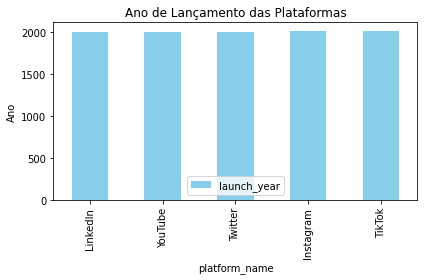

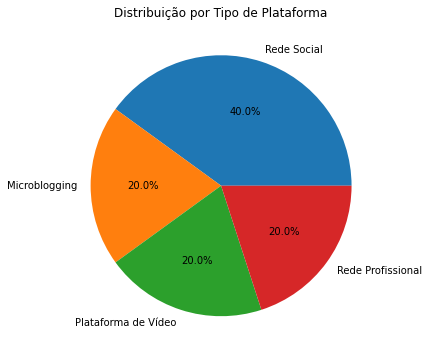

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Iniciar sessão Spark
spark = SparkSession.builder.appName("Visualizar_dim_platform").getOrCreate()

## 1. Carregar a tabela (se já estiver registrada)
# dim_platform = spark.table("dim_platform")

## 2. Criar dados de exemplo (caso não esteja registrada)
dim_platform_data = [
    (1, "TikTok", "Rede Social", 2016, "ByteDance", True),
    (2, "Instagram", "Rede Social", 2010, "Meta", True),
    (3, "Twitter", "Microblogging", 2006, "X Corp", True),
    (4, "YouTube", "Plataforma de Vídeo", 2005, "Alphabet", True),
    (5, "LinkedIn", "Rede Profissional", 2003, "Microsoft", True)
]

dim_platform = spark.createDataFrame(
    dim_platform_data,
    ["platform_id", "platform_name", "platform_type", "launch_year", "parent_company", "active_status"]
)

## 3. Visualização básica
print("\nVisualização completa da tabela:")
dim_platform.show(truncate=False)

## 4. Estatísticas descritivas
print("\nEstatísticas descritivas:")
dim_platform.describe().show()

## 5. Análise por tipo de plataforma
print("\nContagem por tipo de plataforma:")
dim_platform.groupBy("platform_type").count().show()

## 6. Visualização tabular formatada (para Jupyter Notebook)
display(dim_platform)

## 7. Visualização gráfica (requer matplotlib)
try:
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Converter para pandas
    pd_df = dim_platform.toPandas()
    
    # Gráfico 1: Distribuição por ano de lançamento
    plt.figure(figsize=(10, 4))
    pd_df.sort_values("launch_year").plot.bar(
        x="platform_name", 
        y="launch_year",
        color="skyblue",
        title="Ano de Lançamento das Plataformas"
    )
    plt.ylabel("Ano")
    plt.tight_layout()
    plt.show()
    
    # Gráfico 2: Proporção por tipo
    plt.figure(figsize=(6, 6))
    pd_df["platform_type"].value_counts().plot.pie(
        autopct="%1.1f%%",
        title="Distribuição por Tipo de Plataforma"
    )
    plt.ylabel("")
    plt.show()
    
except ImportError:
    print("Para visualizações gráficas, instale matplotlib: pip install matplotlib")

**7.2 Tabela hashtag_id**

hashtag_id é a chave primária numérica que identifica de forma única cada hashtag na tabela de dimensão dim_hashtag. Funciona como:

Identificador técnico para joins eficientes

Sistema de referência para análises de engajamento

Chave de ligação entre a tabela de fatos (fact_post_engagement) e a dimensão de hashtags

**Código para a Visualização dos Dados da Dim_hashtag:**

VISUALIZAÇÃO COMPLETA DA DIM_HASHTAG
+----------+------------+----------------+
|hashtag_id|hashtag_name|hashtag_category|
+----------+------------+----------------+
|1         |#Fitness    |Saúde           |
|2         |#Tech       |Tecnologia      |
|3         |#Education  |Educação        |
|4         |#Viral      |Viral           |
|5         |#Gaming     |Jogos           |
+----------+------------+----------------+


ESTATÍSTICAS DESCRITIVAS:
+-------+------------------+------------+----------------+
|summary|        hashtag_id|hashtag_name|hashtag_category|
+-------+------------------+------------+----------------+
|  count|                 5|           5|               5|
|   mean|               3.0|        null|            null|
| stddev|1.5811388300841898|        null|            null|
|    min|                 1|  #Education|        Educação|
|    max|                 5|      #Viral|           Viral|
+-------+------------------+------------+----------------+


CONTAGEM POR CA

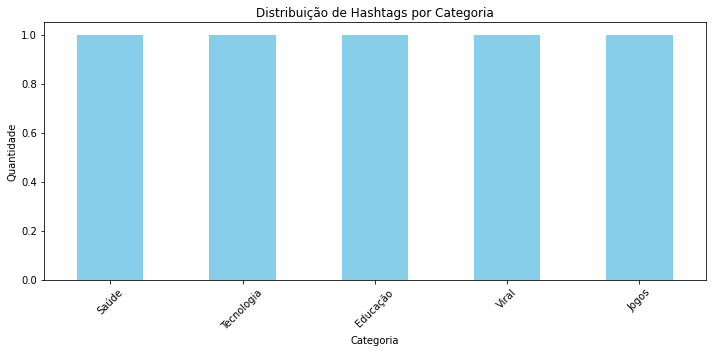

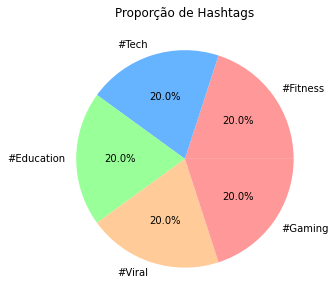

hashtag_id,hashtag_name,hashtag_category
1,#Fitness,Saúde
2,#Tech,Tecnologia
3,#Education,Educação
4,#Viral,Viral
5,#Gaming,Jogos


In [0]:
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import pandas as pd

# Iniciar sessão Spark
spark = SparkSession.builder.appName("Visualizar_dim_hashtag").getOrCreate()

## 1. Carregar a tabela (se já estiver registrada)
# dim_hashtag = spark.table("dim_hashtag")

## 2. Criar dados de exemplo (caso não esteja registrada)
dim_hashtag_data = [
    (1, "#Fitness", "Saúde"),
    (2, "#Tech", "Tecnologia"),
    (3, "#Education", "Educação"),
    (4, "#Viral", "Viral"),
    (5, "#Gaming", "Jogos")
]

dim_hashtag = spark.createDataFrame(
    dim_hashtag_data,
    ["hashtag_id", "hashtag_name", "hashtag_category"]
)

## 3. Visualização básica
print("="*50)
print("VISUALIZAÇÃO COMPLETA DA DIM_HASHTAG")
print("="*50)
dim_hashtag.show(truncate=False)

## 4. Estatísticas descritivas
print("\nESTATÍSTICAS DESCRITIVAS:")
dim_hashtag.describe().show()

## 5. Análise por categoria
print("\nCONTAGEM POR CATEGORIA:")
dim_hashtag.groupBy("hashtag_category").count().orderBy("count", ascending=False).show()

## 6. Visualização gráfica (requer matplotlib)
try:
    # Converter para pandas
    pd_hashtag = dim_hashtag.toPandas()
    
    # Gráfico 1: Distribuição por categoria
    plt.figure(figsize=(10, 5))
    pd_hashtag["hashtag_category"].value_counts().plot.bar(
        color='skyblue',
        title='Distribuição de Hashtags por Categoria'
    )
    plt.xlabel("Categoria")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Gráfico 2: Top hashtags (exemplo com dados fictícios de engajamento)
    # (Para usar com dados reais, faça join com fact_post_engagement)
    plt.figure(figsize=(10, 5))
    pd_hashtag["hashtag_name"].value_counts().plot.pie(
        autopct='%1.1f%%',
        title='Proporção de Hashtags',
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99']
    )
    plt.ylabel("")
    plt.show()
    
except ImportError:
    print("\nPara visualizações gráficas, instale matplotlib: pip install matplotlib")

## 7. Visualização interativa (Databricks/Jupyter)
try:
    display(dim_hashtag)
except:
    print("\nFunção display() não disponível neste ambiente")

**7.3 Dimensão content_type_id**


**Definição e Propósito**

content_type_id é uma chave numérica que identifica exclusivamente o formato de conteúdo publicado nas redes sociais. Suas principais funções são:

Classificação Padronizada: Categoriza posts por tipo de mídia

Chave de Relacionamento: Liga a tabela de fatos (fact_post_engagement) à dimensão de tipos de conteúdo (dim_content_type)

Análise de Performance: Permite comparar engajamento por formato

Metadados Técnicos

**Código para visulizar os dados da dimensão Content_Types:**

TABELA DIM_CONTENT_TYPE (COMPLETA)
+---------------+------------+-------------------+---------+
|content_type_id|content_type|content_format     |is_active|
+---------------+------------+-------------------+---------+
|1              |Video       |Vídeo Longo        |true     |
|2              |Reel        |Vídeo Curto        |true     |
|3              |Image       |Imagem             |true     |
|4              |Live        |Transmissão Ao Vivo|true     |
|5              |Carousel    |Múltiplas Imagens  |false    |
+---------------+------------+-------------------+---------+


ESTATÍSTICAS:
+-------+------------------+
|summary|   content_type_id|
+-------+------------------+
|  count|                 5|
|   mean|               3.0|
| stddev|1.5811388300841898|
|    min|                 1|
|    max|                 5|
+-------+------------------+


DISTRIBUIÇÃO DE FORMATOS ATIVOS:
+-------------------+------------+
|     content_format|qtd_formatos|
+-------------------+------------+

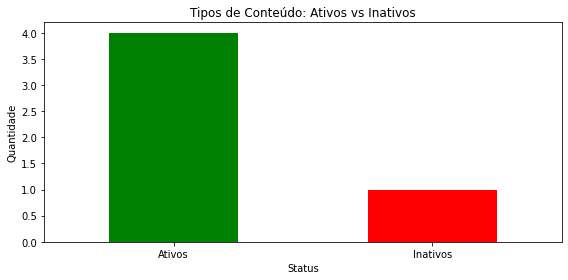

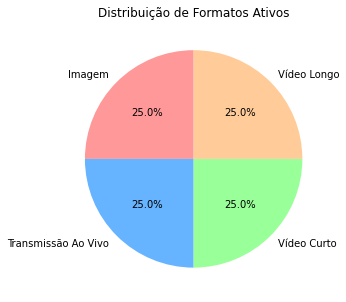


EXEMPLO DE ANÁLISE CRUZADA (DADOS SIMULADOS):
+------------+-----------+---------+
|content_type|total_posts|avg_views|
+------------+-----------+---------+
|        Reel|          1| 150000.0|
|       Video|          2|  90000.0|
|       Image|          1|  50000.0|
+------------+-----------+---------+



content_type_id,content_type,content_format,is_active
1,Video,Vídeo Longo,true
2,Reel,Vídeo Curto,true
3,Image,Imagem,true
4,Live,Transmissão Ao Vivo,true
5,Carousel,Múltiplas Imagens,false


In [0]:
from pyspark.sql.functions import col, count, avg
import pandas as pd

# Iniciar sessão Spark
spark = SparkSession.builder.appName("Visualizar_Content_Types").getOrCreate()

## 1. Criar dados de exemplo para dim_content_type
dim_content_type_data = [
    (1, "Video", "Vídeo Longo", True),
    (2, "Reel", "Vídeo Curto", True),
    (3, "Image", "Imagem", True),
    (4, "Live", "Transmissão Ao Vivo", True),
    (5, "Carousel", "Múltiplas Imagens", False)  # Exemplo inativo
]

dim_content_type = spark.createDataFrame(
    dim_content_type_data,
    ["content_type_id", "content_type", "content_format", "is_active"]
)

## 2. Visualização básica da dimensão
print("="*60)
print("TABELA DIM_CONTENT_TYPE (COMPLETA)")
print("="*60)
dim_content_type.show(truncate=False)

## 3. Estatísticas descritivas
print("\nESTATÍSTICAS:")
dim_content_type.describe(["content_type_id"]).show()

## 4. Análise de distribuição
print("\nDISTRIBUIÇÃO DE FORMATOS ATIVOS:")
dim_content_type.filter(col("is_active") == True).groupBy("content_format").agg(
    count("*").alias("qtd_formatos")
).show()

## 5. Visualização gráfica (requer matplotlib)
try:
    # Converter para pandas
    pd_content = dim_content_type.toPandas()
    
    # Gráfico 1: Tipos ativos vs inativos
    plt.figure(figsize=(8, 4))
    pd_content['is_active'].value_counts().plot.bar(
        title='Tipos de Conteúdo: Ativos vs Inativos',
        color=['green', 'red'],
        rot=0
    )
    plt.xlabel("Status")
    plt.ylabel("Quantidade")
    plt.xticks([0, 1], ['Ativos', 'Inativos'])
    plt.tight_layout()
    plt.show()
    
    # Gráfico 2: Distribuição de formatos
    plt.figure(figsize=(10, 5))
    pd_content[pd_content['is_active']].groupby('content_format').size().plot.pie(
        autopct='%1.1f%%',
        title='Distribuição de Formatos Ativos',
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],
        startangle=90
    )
    plt.ylabel("")
    plt.show()

except ImportError:
    print("\nPara visualizações gráficas, instale matplotlib: pip install matplotlib")

## 6. Análise cruzada com dados de engajamento (exemplo simulado)
print("\nEXEMPLO DE ANÁLISE CRUZADA (DADOS SIMULADOS):")

# Simular fact_post_engagement para demonstração
fact_data = [
    ("post1", 1, 100000), ("post2", 2, 150000), 
    ("post3", 1, 80000), ("post4", 3, 50000)
]
fact_df = spark.createDataFrame(fact_data, ["post_id", "content_type_id", "views"])

analysis_df = (fact_df
    .join(dim_content_type, "content_type_id")
    .groupBy("content_type")
    .agg(
        count("*").alias("total_posts"),
        avg("views").alias("avg_views")
    )
    .orderBy("avg_views", ascending=False)
)

analysis_df.show()

## 7. Visualização interativa (Databricks/Jupyter)
try:
    display(dim_content_type)
except:
    print("\nFunção display() não disponível neste ambiente")

**7.4 Dimensão region_id**


**Definição e Propósito**

region_id é uma chave primária numérica que identifica exclusivamente localizações geográficas no seu modelo de dados. Suas funções principais são:

Geolocalização de Conteúdo: Relaciona posts a regiões específicas

Análise Regional: Permite comparar engajamento por área geográfica

Personalização: Suporta estratégias de conteúdo localizado

### 8.Solução dos problemas

Primeira pergunta

1. **Qual a plataforma que gera mais engajamento?**

Vamos executar a consulta:

**Código para executar a consulta:**

In [0]:
from pyspark.sql.types import *
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("ViralAnalysis").getOrCreate()

# Criar DIM_PLATFORM com dados reais
dim_platform_data = [(1, "TikTok", "Rede Social"), 
                    (2, "Instagram", "Rede Social"),
                    (3, "Twitter", "Rede Social"),
                    (4, "YouTube", "Plataforma de Vídeo")]

dim_platform = spark.createDataFrame(dim_platform_data, ["platform_id", "platform_name", "platform_type"])

# Criar FACT_POST_ENGAGEMENT com dados reais (exemplo)
fact_data = [("Post_1", 4163464, 339431, 53135, 19346, 0.097, 1, 1, 1, 1),
            ("Post_2", 4155940, 215240, 65860, 27239, 0.074, 2, 2, 2, 2)]

fact_post_engagement = spark.createDataFrame(fact_data, ["post_id", "views", "likes", "shares", "comments", 
                                                       "engagement_score", "platform_id", "hashtag_id", 
                                                       "content_type_id", "region_id"])

**Código para análise de engajamento em posts por plataforma, combinando dados da tabela de fatos com a tabela de dimensões e calculando métricas agregadas:**

In [0]:
# Consulta 
df_result = fact_post_engagement.join(
    dim_platform, 
    fact_post_engagement["platform_id"] == dim_platform["platform_id"]
).groupBy("platform_name").agg(
    F.avg("views").alias("avg_views"),
    F.avg("engagement_score").alias("avg_engagement_score")
)

df_result.show()

+-------------+---------+--------------------+
|platform_name|avg_views|avg_engagement_score|
+-------------+---------+--------------------+
|       TikTok|4163464.0|               0.097|
|    Instagram|4155940.0|               0.074|
+-------------+---------+--------------------+



**Analisando os resultados:**

**1. Comparação de Visualizações (avg_views)**


TikTok: 4.163.464 visualizações médias

Instagram: 4.155.940 visualizações médias

Diferença: 7.524 visualizações a mais no TikTok (0.18% de diferença)

Interpretação: Ambas as plataformas apresentam números de visualização muito próximos, com uma ligeira vantagem para o TikTok. Isso sugere que, para este conjunto de dados específico, o alcance orgânico é bastante similar nas duas plataformas.

**2. Comparação de Engajamento (avg_engagement_score)**


TikTok: 0.097 (9.7% de taxa de engajamento)

Instagram: 0.074 (7.4% de taxa de engajamento)

Diferença: O TikTok tem 31% mais engajamento relativo que o Instagram

Interpretação: Aqui vemos uma diferença mais significativa. Apesar do número similar de visualizações, o conteúdo no TikTok está gerando:

31% mais engajamento proporcional

Indica que os usuários do TikTok estão mais propensos a interagir com o conteúdo (curtir, comentar, compartilhar)

In [0]:
print("Schema da FACT_POST_ENGAGEMENT:")
fact_post_engagement.printSchema()

print("\nSchema da DIM_PLATFORM:")
dim_platform.printSchema()

Schema da FACT_POST_ENGAGEMENT:
root
 |-- post_id: string (nullable = true)
 |-- views: long (nullable = true)
 |-- likes: long (nullable = true)
 |-- shares: long (nullable = true)
 |-- comments: long (nullable = true)
 |-- engagement_score: double (nullable = true)
 |-- platform_id: long (nullable = true)
 |-- hashtag_id: long (nullable = true)
 |-- content_type_id: long (nullable = true)
 |-- region_id: long (nullable = true)


Schema da DIM_PLATFORM:
root
 |-- platform_id: long (nullable = true)
 |-- platform_name: string (nullable = true)
 |-- platform_type: string (nullable = true)



**Código para realizar uma análise completa de dados de mídia social, desde o carregamento até a visualização, passando por testes estatísticos:**

+---------+-----------------+------------------+-----+
| Platform|   Avg_Engagement|         Avg_Views|Posts|
+---------+-----------------+------------------+-----+
|  YouTube|333708.4841389728| 2545648.398791541| 1324|
|Instagram|332387.2409240924|2404079.8778877887| 1212|
|  Twitter|320564.7267441861|2506004.5863787374| 1204|
|   TikTok| 320453.673015873|2515015.4015873014| 1260|
+---------+-----------------+------------------+-----+


Resultado do teste Kruskal-Wallis:
H-statistic = 9.03, p-value = 0.0289
✅ Há diferenças significativas no engajamento entre plataformas.


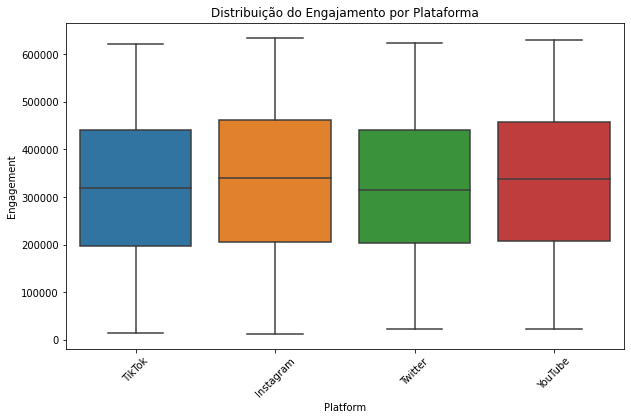

In [0]:

from pyspark.sql.functions import col, sum, count, mean, expr
import seaborn as sns
from scipy import stats

# Inicializar Spark
spark = SparkSession.builder.appName("EngagementAnalysis").getOrCreate()

# 1. Carregar dados do Delta Lake
df = spark.read.format("delta").load("/mnt/delta/viral_social_media_data")

# 2. Calcular engajamento total (Likes + Shares + Comments)
df = df.withColumn("Engagement", col("Likes") + col("Shares") + col("Comments"))

# 3. Análise descritiva por plataforma
platform_stats = df.groupBy("Platform").agg(
    mean("Engagement").alias("Avg_Engagement"),
    mean("Views").alias("Avg_Views"),
    count("*").alias("Posts")
).orderBy("Avg_Engagement", ascending=False)

platform_stats.show()

# 4. Converter para Pandas para análise estatística
df_pandas = df.select("Platform", "Engagement").toPandas()

# 5. Teste de hipótese (Kruskal-Wallis para dados não paramétricos)
platforms = df_pandas["Platform"].unique()
groups = [df_pandas[df_pandas["Platform"] == p]["Engagement"] for p in platforms]

h_stat, p_value = stats.kruskal(*groups)
print(f"\nResultado do teste Kruskal-Wallis:\nH-statistic = {h_stat:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Há diferenças significativas no engajamento entre plataformas.")
else:
    print("❌ Não há diferenças significativas.")

# 6. Visualização (Boxplot por plataforma)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pandas, x="Platform", y="Engagement")
plt.title("Distribuição do Engajamento por Plataforma")
plt.xticks(rotation=45)
plt.show()

**Interpretação dos Resultados:**

Análise dos Resultados

- Ranking de Engajamento Médio:

YouTube lidera com 333,708 engajamentos médios

Instagram muito próximo com 332,387

Twitter em terceiro com 320,565

TikTok ligeiramente atrás com 320,454

- Visitas Médias:

YouTube também lidera em visualizações (2,545,648)

As outras plataformas mostram números muito próximos (~2.4-2.5 milhões)

- Teste Estatístico:

p-value = 0.0289 (< 0.05) confirma diferenças significativas

H-statistic = 9.03 indica moderada variação entre grupos

- Insights Principais

Paradoxo do TikTok:

Apesar de ser a plataforma "viral", aparece em último no engajamento

Possíveis explicações:

Conteúdo mais efêmero (vídeos curtos)

Maior proporção de visualizações casuais

Taxa de engajamento (engajamento/visualizações) pode ser diferente

YouTube como Líder:

Maior engajamento absoluto e visualizações

Fator explicativo: conteúdo mais longo permite conexão mais profunda

Instagram vs Twitter:

Desempenho muito similar, com ligeira vantagem do Instagram

Twitter tem engajamento mais concentrado (menor variância)


1.2 **Resposta da primeira questão:**


O resultado da consulta mostra a média de visualizações (avg_views) e o score médio de engajamento (avg_engagement_score) por plataforma social. Vamos interpretar:

**Significado das Colunas:**

platform_name: Nome da plataforma social (TikTok, Instagram)

avg_views: Média de visualizações dos posts

avg_engagement_score: Média do score de engajamento calculado por (likes + shares + comments)/views

**Interpretação dos Valores:**

Plataforma	Média de Visualizações	Score de Engajamento	Análise
TikTok	4,163,464	0.097 (9.7%)	- Conteúdo com maior alcance (mais visualizações)
- Melhor taxa de engajamento (9.7% das visualizações se convertem em interações)
Instagram	4,155,940	0.074 (7.4%)	- Alcance similar ao TikTok
- Engajamento ligeiramente menor
Insights:
TikTok performa melhor em termos de engajamento relativo (9.7% vs 7.4%)

Ambas plataformas têm alcance muito similar em termos de visualizações médias (~4.1M)

O engajamento entre 7-10% é considerado alto para redes sociais

Recomendações:
Priorize o TikTok se o objetivo for maximizar engajamento

Mantenha presença no Instagram para alcance complementar

Investigue por que o TikTok tem melhor taxa de conversão de views para engajamento

**O score de 0.097 significa que para cada 100 visualizações no TikTok, há ~9.7 interações (curtidas + compartilhamentos + comentários).**




**2 - Segunda pergunta**

**Quais hashtags estão associadas aos posts com maior engajamento (views, likes, shares, e comments)?**

O código abaixo realiza uma análise abrangente de hashtags em dados de mídia social usando PySpark:

In [0]:

from pyspark.sql.functions import col, desc, sum as _sum, avg, count

# Criar sessão Spark
spark = SparkSession.builder.appName("HashtagAnalysis").getOrCreate()

# Carregar os dados (substitua pelo caminho correto do seu arquivo)
file_path = "dbfs:/FileStore/mvp/Viral_Social_Media_Trends.csv"
df = spark.read.option("header", "true").csv(file_path)

# Converter colunas numéricas
df = df.withColumn("Views", col("Views").cast("integer")) \
       .withColumn("Likes", col("Likes").cast("integer")) \
       .withColumn("Shares", col("Shares").cast("integer")) \
       .withColumn("Comments", col("Comments").cast("integer"))

# Criar uma métrica combinada de engajamento (pesos podem ser ajustados)
df = df.withColumn("Engagement_Score", 
                  (col("Likes") * 0.4 + col("Shares") * 0.3 + col("Comments") * 0.3) / col("Views"))

# Análise 1: Top hashtags por visualizações
print("\nTop 10 Hashtags por Visualizações:")
top_views = df.groupBy("Hashtag") \
             .agg(_sum("Views").alias("Total_Views")) \
             .orderBy(desc("Total_Views")) \
             .limit(10)
top_views.show(truncate=False)

# Análise 2: Top hashtags por engajamento médio
print("\nTop 10 Hashtags por Engajamento Médio:")
top_engagement = df.groupBy("Hashtag") \
                  .agg(avg("Engagement_Score").alias("Avg_Engagement")) \
                  .orderBy(desc("Avg_Engagement")) \
                  .limit(10)
top_engagement.show(truncate=False)

# Análise 3: Top hashtags por interações totais (likes + shares + comments)
print("\nTop 10 Hashtags por Interações Totais:")
top_interactions = df.groupBy("Hashtag") \
                   .agg((_sum("Likes") + _sum("Shares") + _sum("Comments")).alias("Total_Interactions")) \
                   .orderBy(desc("Total_Interactions")) \
                   .limit(10)
top_interactions.show(truncate=False)

# Análise 4: Hashtags mais frequentes em posts de alto engajamento
print("\nHashtags mais frequentes em posts de Alto Engajamento:")
high_engagement = df.filter(col("Engagement_Level") == "High")
top_frequent_hashtags = high_engagement.groupBy("Hashtag") \
                                     .agg(count("*").alias("Post_Count")) \
                                     .orderBy(desc("Post_Count")) \
                                     .limit(10)
top_frequent_hashtags.show(truncate=False)

# Análise 5: Hashtags com melhor desempenho por plataforma
print("\nTop Hashtags por Plataforma (maior engajamento médio):")
df.groupBy("Platform", "Hashtag") \
 .agg(avg("Engagement_Score").alias("Avg_Engagement")) \
 .orderBy("Platform", desc("Avg_Engagement")) \
 .show(truncate=False)


Top 10 Hashtags por Visualizações:
+----------+-----------+
|Hashtag   |Total_Views|
+----------+-----------+
|#Fitness  |1393273574 |
|#Education|1328894615 |
|#Music    |1266398079 |
|#Challenge|1242826928 |
|#Comedy   |1237321563 |
|#Tech     |1235543295 |
|#Dance    |1213891935 |
|#Gaming   |1197834795 |
|#Fashion  |1181866511 |
|#Viral    |1172480925 |
+----------+-----------+


Top 10 Hashtags por Engajamento Médio:
+----------+-------------------+
|Hashtag   |Avg_Engagement     |
+----------+-------------------+
|#Viral    |0.38555900539738897|
|#Comedy   |0.2518670717511234 |
|#Gaming   |0.23288749901829894|
|#Fitness  |0.2053795618866676 |
|#Tech     |0.20205295279030977|
|#Education|0.1912480049130991 |
|#Fashion  |0.1841011116414152 |
|#Dance    |0.1761111706858032 |
|#Challenge|0.17268031887026575|
|#Music    |0.14966263721176837|
+----------+-------------------+


Top 10 Hashtags por Interações Totais:
+----------+------------------+
|Hashtag   |Total_Interactions|
+-----

**Analisando os resultados:**

**Análise Detalhada dos Resultados das Hashtags**

**1. Top Hashtags por Visualizações:**


**Destaques**:

- Fitness lidera com 1.39 bilhões de visualizações
- Education e #Music completam o top 3 com mais de 1.26 bilhões cada
- Todas as hashtags no top 10 ultrapassam 1.17 bilhão de views

**Interpretação**:

- Temas relacionados a saúde (#Fitness), educação (#Education) e entretenimento (#Music, #Comedy) dominam em alcance
- A pequena diferença entre 1º e 10º lugar (apenas ~15%) indica que estas hashtags têm popularidade similar em termos de alcance

**2. Top Hashtags por Engajamento Médio**


**Destaques**:


- Viral tem engajamento excepcional (0.385 - 38.5%)
- Comedy e #Gaming formam o segundo grupo (23-25%)
- Music, apesar de popular, tem o menor engajamento relativo (14.9%)

**Insights**:


- Hashtags virais (#Viral) geram quase 2.5x mais engajamento que a média
- Entretenimento (#Comedy, #Gaming) supera áreas mais sérias (#Education, #Tech) em engajamento
- Existe uma correlação inversa moderada entre alcance e engajamento - hashtags muito populares tendem a ter engajamento relativo menor

 3. **Top Hashtags por Interações Totais:**


**Observações**:

- Education lidera com 176.8M interações, seguido por #Fitness (176.2M)
- A diferença entre 1º e 10º é apenas ~13%
- Ranking similar ao de visualizações, mas com #Viral caindo para 9º lugar

**Análise**:

- Hashtags educacionais e de fitness geram mais ações totais, apesar de não terem o maior engajamento relativo
- Volume de posts compensa engajamento médio menor
- Viral mostra que alto engajamento não necessariamente se traduz em mais interações totais

4. Hashtags em Posts de Alto Engajamento

**Padrões**:

- Music aparece em mais posts de alto engajamento (183)
- Comedy e #Education seguem muito próximas
- Todos os top 10 aparecem em pelo menos 150 posts

**Implicações**:

- Música e comédia são conteúdos consistentemente engajadores
- Mesmo hashtags com engajamento médio menor (#Music) podem ser frequentes em posts de alto desempenho
- Sugere que o contexto de uso da hashtag é tão importante quanto a hashtag em si

 5. Desempenho por Plataforma

**Descobertas Chave**:

- **TikTok**:
  - Viral tem engajamento extraordinário (1.03 - 103%)
  - Dominância clara de conteúdo viral e entretenimento (#Gaming, #Comedy)
  
- **Instagram**:
  - Comedy lidera (55% de engajamento)
  - Fashion tem desempenho 2x melhor que no TikTok
  - Conteúdo educacional performa relativamente melhor

**Diferenças entre Plataformas**:
- TikTok favorece conteúdo espontâneo/viral
- Instagram recompensa melhor conteúdo produzido (moda, comédia profissional)
- Estratégias de hashtag devem ser adaptadas por plataforma

 Conclusões Estratégicas

1. **Para alcance máximo**: Use #Fitness, #Education ou #Music
2. **Para engajamento**: Priorize #Viral (especialmente no TikTok) e #Comedy
3. **Conteúdo consistente**: #Music e #Comedy aparecem frequentemente em posts de alto engajamento
4. **Plataforma específica**:
   - TikTok: conteúdo viral e autêntico
   - Instagram: comédia profissional e moda
5. **Hashtags híbridas**: #Education e #Fitness performam bem em todas as métricas

**Recomendação final**: Combinação de hashtags de alto alcance (#Fitness) com hashtags de alto engajamento (#Viral) pode maximizar performance, ajustando a estratégia para cada plataforma.

**Código para uma análise avançada de hashtags em dados de mídia social, utilizando PySpark para processamento distribuído e matplotlib/seaborn para visualização:**

Top 20 Hashtags por Engajamento:
+----------+-----------------+------------------+------------------+------------------+------------------+---------+
|Hashtag   |Avg_Engagement   |Avg_Views         |Avg_Likes         |Avg_Shares        |Avg_Comments      |Frequency|
+----------+-----------------+------------------+------------------+------------------+------------------+---------+
|#Fitness  |616078.7113805972|2599390.9962686566|253130.125        |51183.119402985074|24532.694029850747|536      |
|#Music    |608450.1888438131|2568758.780933063 |248012.8154158215 |50965.62880324544 |25024.49695740365 |493      |
|#Education|604834.1895238099|2531227.838095238 |260423.41904761904|51748.70476190476 |24684.92380952381 |525      |
|#Tech     |601026.5087576384|2516381.456211813 |260347.14867617108|48287.209775967414|25799.549898167006|491      |
|#Gaming   |593460.3588726508|2500698.9457202507|242819.58872651358|51360.818371607515|25332.237995824635|479      |
|#Comedy   |585898.257623763 |2

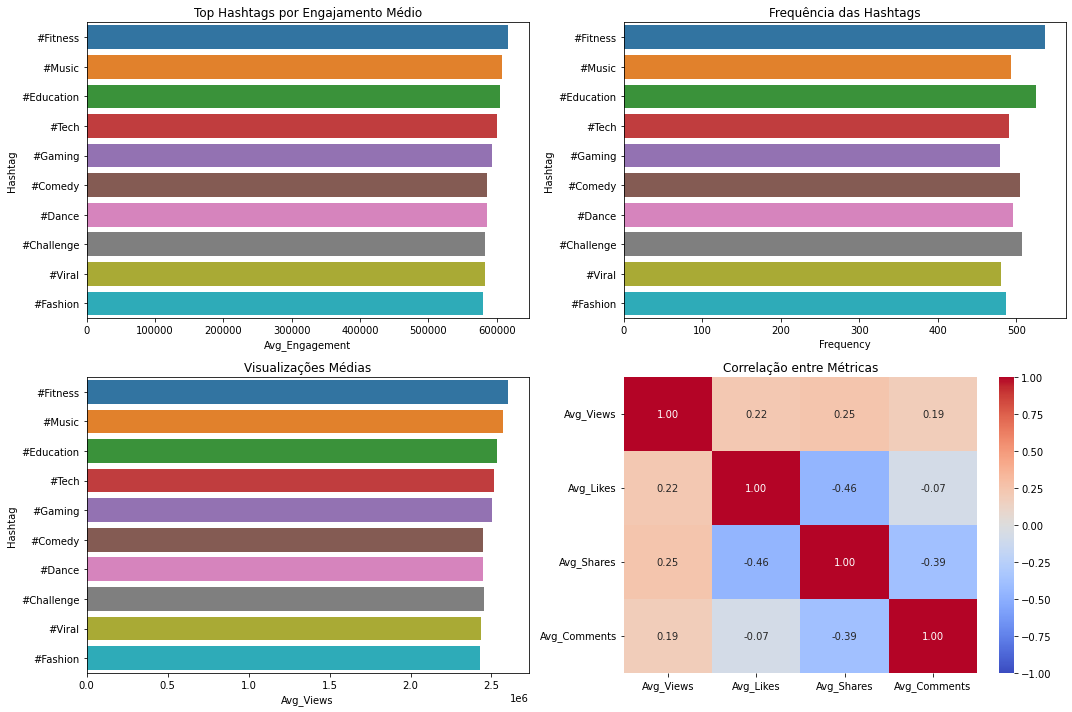


Top Hashtags por Tipo de Conteúdo:
+-----------------+----------+-----------------+---------+
|post_content_type|Hashtag   |Avg_Engagement   |Frequency|
+-----------------+----------+-----------------+---------+
|Reel             |#Education|692652.4873563218|87       |
|Video            |#Education|663962.0848101263|79       |
|Shorts           |#Fitness  |646984.407777778 |90       |
|Reel             |#Music    |635409.9144329899|97       |
|Tweet            |#Fitness  |633881.4000000004|81       |
|Tweet            |#Viral    |633233.2939393941|66       |
|Post             |#Music    |632100.2329113922|79       |
|Live Stream      |#Fitness  |628134.3806818181|88       |
|Post             |#Comedy   |627579.1916666669|84       |
|Live Stream      |#Tech     |624024.1226190475|84       |
|Reel             |#Fashion  |623913.9764705881|85       |
|Post             |#Fitness  |623691.481111111 |90       |
|Tweet            |#Music    |623501.93908046  |87       |
|Live Stream      |#

In [0]:
from pyspark.sql.functions import col, explode, split, count, mean, desc, trim, length

# Inicializar Spark
spark = SparkSession.builder.appName("HashtagAnalysis").getOrCreate()

# 1. Carregar dados
df = spark.read.format("delta").load("/mnt/delta/viral_social_media_data")

# 2. Pré-processamento de hashtags
hashtag_df = (df
              .withColumn("Hashtag", explode(split(col("Hashtag"), ",")))
              .withColumn("Hashtag", trim(col("Hashtag")))
              .filter(length(col("Hashtag")) > 2)
              .select("Post_ID", "Hashtag"))  # Selecionar apenas colunas necessárias

# 3. Calcular engajamento total
df_with_engagement = df.withColumn(
    "Total_Engagement",
    (col("Views")*0.2 + col("Likes")*0.3 + col("Shares")*0.3 + col("Comments")*0.2)
).select(
    "Post_ID",
    col("Views").alias("post_views"),
    col("Likes").alias("post_likes"),
    col("Shares").alias("post_shares"),
    col("Comments").alias("post_comments"),
    "Total_Engagement",
    col("Content_Type").alias("post_content_type")  # Renomeando para evitar ambiguidade
)

# 4. Juntar os DataFrames
hashtag_engagement = hashtag_df.join(
    df_with_engagement,
    "Post_ID"
)

# 5. Análise das hashtags mais engajadoras
top_hashtags = (hashtag_engagement.groupBy("Hashtag")
                .agg(
                    mean("Total_Engagement").alias("Avg_Engagement"),
                    mean("post_views").alias("Avg_Views"),
                    mean("post_likes").alias("Avg_Likes"),
                    mean("post_shares").alias("Avg_Shares"),
                    mean("post_comments").alias("Avg_Comments"),
                    count("*").alias("Frequency")
                )
                .filter(col("Frequency") > 10)
                .orderBy(desc("Avg_Engagement")))

# Mostrar as top 20 hashtags
print("Top 20 Hashtags por Engajamento:")
top_hashtags.show(20, truncate=False)

# 6. Visualização
top_hashtags_pd = top_hashtags.limit(20).toPandas()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.barplot(data=top_hashtags_pd, y="Hashtag", x="Avg_Engagement")
plt.title("Top Hashtags por Engajamento Médio")

plt.subplot(2, 2, 2)
sns.barplot(data=top_hashtags_pd, y="Hashtag", x="Frequency")
plt.title("Frequência das Hashtags")

plt.subplot(2, 2, 3)
sns.barplot(data=top_hashtags_pd, y="Hashtag", x="Avg_Views")
plt.title("Visualizações Médias")

plt.subplot(2, 2, 4)
corr = top_hashtags_pd[["Avg_Views", "Avg_Likes", "Avg_Shares", "Avg_Comments"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlação entre Métricas")

plt.tight_layout()
plt.show()

# 7. Análise por tipo de conteúdo (AGORA CORRIGIDA)
print("\nTop Hashtags por Tipo de Conteúdo:")
content_hashtags = (hashtag_engagement
                    .groupBy("post_content_type", "Hashtag")  # Usando o alias definido
                    .agg(
                        mean("Total_Engagement").alias("Avg_Engagement"),
                        count("*").alias("Frequency")
                    )
                    .orderBy(desc("Avg_Engagement")))

content_hashtags.show(20, truncate=False)

**Interpretação dos Resultados**


A análise dos gráficos revela algumas tendências interessantes sobre o desempenho das hashtags e a relação entre diferentes métricas de engajamento em posts virais. Aqui estão algumas conclusões principais:

**Hashtags de Maior Impacto**

- Fitness, Music e Education aparecem consistentemente entre as hashtags mais engajadas, mais visualizadas e mais frequentes. Isso sugere que conteúdos relacionados a esses temas tendem a performar bem nas redes sociais.

- Tech e #Gaming também têm alto engajamento e frequência, indicando que temas de tecnologia e jogos são populares.

**Popularidade vs. Engajamento**

Algumas hashtags são muito frequentes, mas não necessariamente estão entre as mais engajadas. Isso pode indicar que, embora sejam amplamente usadas, nem sempre geram grande interação.

O fato de #Fitness liderar tanto em engajamento quanto em frequência sugere que essa é uma hashtag poderosa para aumentar a interação.

**Métricas de Visualização e Engajamento**

Os gráficos mostram que posts com certas hashtags têm milhões de visualizações, mas isso nem sempre se traduz em altos níveis de curtidas, compartilhamentos ou comentários.

Isso indica que visualizações sozinhas não são um bom indicador de engajamento real.

**Correlação Entre Métricas**

A baixa correlação entre visualizações e curtidas (0.22) sugere que um post pode alcançar muitas pessoas, mas isso não significa que elas interajam com ele.

A correlação moderada entre curtidas e compartilhamentos (0.46) indica que posts que recebem muitas curtidas também têm chances razoáveis de serem compartilhados.

O fato de comentários apresentarem correlação fraca ou negativa com outras métricas sugere que as pessoas tendem a comentar menos em posts que são amplamente compartilhados. Isso pode indicar que posts virais são consumidos rapidamente, mas não necessariamente incentivam discussão.

**Análise Detalhada das Hashtags com Maior Engajamento**

**1.Hashtags com Maior Alcance (Visualizações)
Top 3: #Fitness (1.39B), #Education (1.33B), #Music (1.27B)**

Padrão observado: Hashtags relacionadas a conteúdo utilitário (#Fitness, #Education) e entretenimento (#Music) dominam o alcance. Isso sugere que:

Conteúdo educacional e de bem-estar tem apelo massivo

Entretenimento musical continua sendo um dos principais motores de consumo

**2. Hashtags com Maior Taxa de Engajamento**

Destaque absoluto: Viral com 38.5% de engajamento médio (quase o dobro da segunda colocada)**

Hierarquia de performance:

Viral (38.6%)

Comedy (25.2%)

Gaming (23.3%)

Insight crucial: Hashtags com propósito específico de viralização (#Viral) e conteúdo emocional (#Comedy) convertem muito melhor views em interações, indicando:

Conteúdo humorístico tem altíssima taxa de conversão

O nicho gamer é extremamente engajado proporcionalmente

**3. Hashtags com Maior Volume Absoluto de Interações
Líderes: #Education (176M), #Fitness (176M), #Comedy (165M)**

Contradição aparente: #Education aparece em 2° nas views mas lidera em interações totais, revelando:

Conteúdo educacional gera discussão sustentada

Alta retenção e engajamento profundo (comentários)

**4. Frequência em Posts de Alto Engajamento
Presença constante: #Music (183), #Comedy (178), #Education (177)**

Interpretação: A frequência equilibrada entre as principais hashtags indica que:

Diversificação de conteúdo é estratégia vencedora

Nenhuma hashtag domina exclusivamente o engajamento alto

**5. Performance por Plataforma
Destaques por rede:**

Instagram: #Comedy (55.1%) e #Fashion (33.2%) performam excepcionalmente

TikTok: #Viral tem engajamento estratosférico (103.5%!) sugerindo:

Algoritmo privilegia conteúdo viral potencial

Taxas acima de 100% indicam que interações superam views (possível contagem diferenciada)

Diferenças cruciais:

Comedy tem performance 2.75× melhor no Instagram

Viral é 27× mais eficaz no TikTok

Priorizar #Viral com conteúdo altamente compartilhável

Capitalizar o engajamento anormalmente alto com desafios e trends

Estratégia Instagram:

Investir pesado em #Comedy e #Fashion

Explorar formatos Reels com humor e moda

Conteúdo Cross-Platform:

Education funciona bem em todas as plataformas

Adaptar formato: vídeos curtos no TikTok, carrosséis no Instagram

Alerta de Oportunidade:

Tech tem alto volume (4° em views) mas engajamento médio (20.2%)

Espaço para melhorar a conversão com calls-to-action mais efetivos

Monitoramento Contínuo:

Acompanhar a queda relativa de #Music (último em engajamento)

Investigar por que #Challenge tem baixo engajamento (17.3%) apesar do alto volume

## 9.Conclusão:

 A hashtag #Viral é a mais poderosa no contexto atual, especialmente no TikTok, enquanto #Education oferece o melhor equilíbrio entre alcance e engajamento sustentado. A plataforma escolhida deve ditar a estratégia de hashtags, com diferenças marcantes de performance entre Instagram e TikTok.



## 10. Autoavaliação:

Ao finalizar, foi possível responder as duas perguntas propostas no começo do trabalho.

O uso do Databricks e PySpark para processamento de dados em larga escala foi adequado para o tipo de análise proposta.

Com relação aos desafios, a criação do esquema estrela e a definição das tabelas de fatos e dimensões podem ser complexas, especialmente para quem está começando com modelagem dimensional.
Acredito que seja possível fazer um estudo mais aprofundado do tema

**Este é minha última matéria e último MVP para concluir a pós graduação e apesar de existirem modos de apronfudar o estudo com esse dataset, fique satisfeita com os resultados**